In [1]:
# Required packages
using CSV
using DifferentialEquations
using OrdinaryDiffEq
using ODE
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using LaTeXStrings
using NLsolve
using Optim
pyplot();
figpath = "C:/Users/pande/Desktop/WorkiingDirectory/SummerJob2019/Figures/paramteropt/"

"C:/Users/pande/Desktop/WorkiingDirectory/SummerJob2019/Figures/paramteropt/"

In [2]:
# Loading csv file and accessing data of Ts, TFe, Tac, Tah
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end
# measurement data
data = [Ts_m TFe_m Tac_m Tah_m]'
# Subsampling measurements
idx = 1:15:N;

In [3]:
# While using coustom ODE we need to change simulation time to iteration to access data
# We define fucntion that change simulation time to iteration for input
# Inputs function given from data
function u_Ifd(t)
    # Iterative value of Ifd from real data
    t=trunc(Int,t/60+1)
    return If[t]
end
function u_It(t)
    # Iterative value of It from real data
    t=trunc(Int,t/60+1)
    return It[t]
end
function u_Twc(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return Twc[t]
end


u_Twc (generic function with 1 method)

# Model 1 starts for analyzing parameter space

In [14]:
# Model 1
function gen(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o = 1.012,4.1813,0.385,0.412,28. 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*chpCu)
    du[2] = (3*Rs*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*chpCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*chpFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o = 1.012,4.1813,0.385,0.412,28. 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

alg_var (generic function with 1 method)

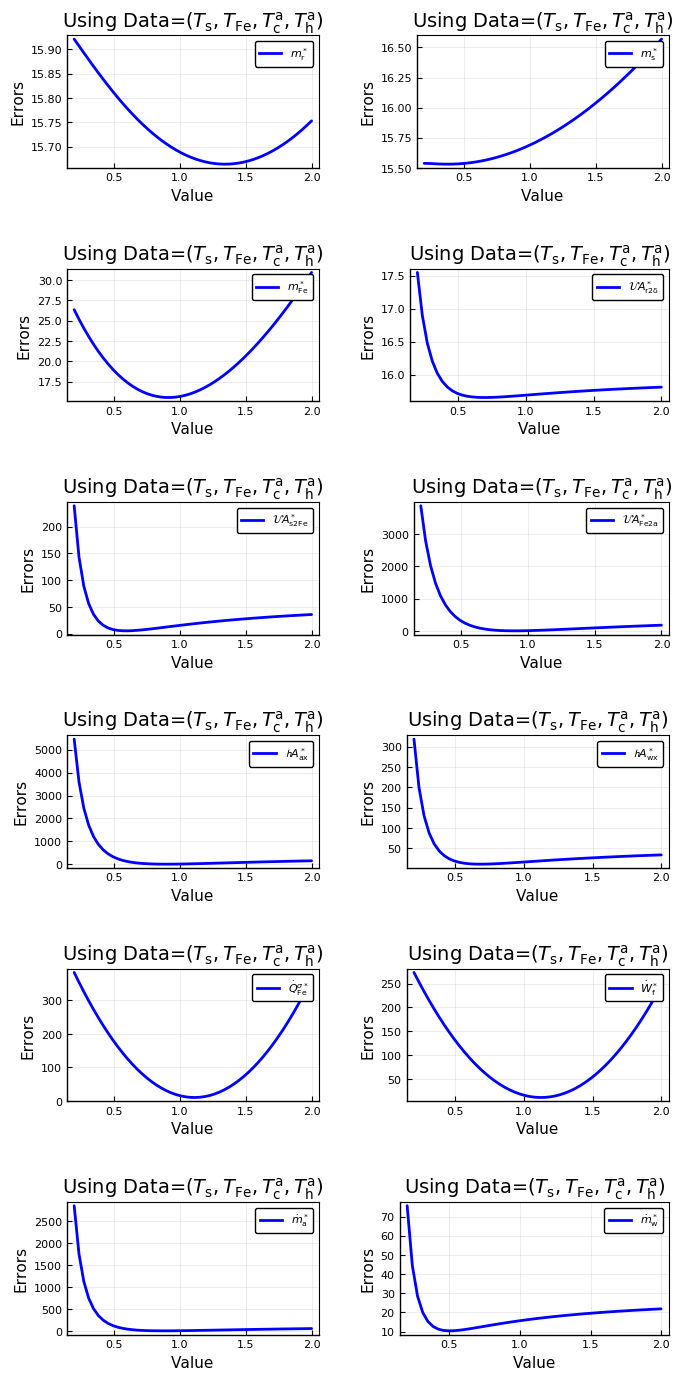

In [15]:
# Using Variable step solver
# Analysing parameter space using Data(Ts,TFe)
# Visualizing each parameters to have either optimum value or not for model1
dt = 60.
u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# custom cost_function
dataTwo = [data[1,:] data[2,:]]'
function cost(par,idx)
    p = fill(1.,12)
    tspan=(0,583*60.)
    p[idx] .= par
    prob = ODEProblem(gen,u0,tspan,p)
    sol = solve(prob,Tsit5(), saveat=dt)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-dataTwo)^2/2/N
end
 #p = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#
using Plots.PlotMeasures
pyplot()
labels = ["\$m_\\mathrm{r}^*\$","\$m_\\mathrm{s}^*\$","\$m_\\mathrm{Fe}^*\$",
    "\$\\mathcal{U}A^*_\\mathrm{r2\\delta}\$","\$\\mathcal{U}A^*_\\mathrm{s2Fe}\$",
    "\$\\mathcal{U}A^*_\\mathrm{Fe2a}\$","\$\\mathcal{h}A^*_\\mathrm{ax}\$","\$\\mathcal{h}A^*_\\mathrm{wx}\$",
    "\$\\dotQ^{\\sigma*}_\\mathrm{Fe}\$","\$\\dotW^*_\\mathrm{f}\$","\$\\dotm^*_\\mathrm{a}\$","\$\\dotm^*_\\mathrm{w}\$"]
pp = range(0.2,2,length=50)
loss = (par) -> cost(par,[1])
fg = [plot(pp,loss.(pp),label=labels[1])]
for i in 2:12
    idx = [i]
    loss = (par) -> cost(par,idx)
    push!(fg,plot(pp,loss.(pp),label=labels[i]))
end
plot(fg...,layout=(6,2),size=(700,1400),framestyle=:box,ylabel="Errors",
    xlabel="Value",lw=2,lc=:blue,legend=:topright,bottom_margin=10mm,right_margin=10mm,title="Using Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$)")
figfile = "VarStepEachParamUsing2data.svg"
savefig(figpath*figfile)

# Analysing parameter space using Data(Ts,TFe, Tac, Tah)
dt = 60.
u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# using only Ts and TFe data
# custom cost_function
function cost(par,idx)
    p = fill(1.,12)
    tspan=(0,583*60.)
    p[idx] .= par
    prob = ODEProblem(gen,u0,tspan,p)
    sol = solve(prob,Tsit5(), saveat=dt)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data)^2/2/N
end
 #p = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#
using Plots.PlotMeasures
pyplot()
labels = ["\$m_\\mathrm{r}^*\$","\$m_\\mathrm{s}^*\$","\$m_\\mathrm{Fe}^*\$",
    "\$\\mathcal{U}A^*_\\mathrm{r2\\delta}\$","\$\\mathcal{U}A^*_\\mathrm{s2Fe}\$",
    "\$\\mathcal{U}A^*_\\mathrm{Fe2a}\$","\$\\mathcal{h}A^*_\\mathrm{ax}\$","\$\\mathcal{h}A^*_\\mathrm{wx}\$",
    "\$\\dotQ^{\\sigma*}_\\mathrm{Fe}\$","\$\\dotW^*_\\mathrm{f}\$","\$\\dotm^*_\\mathrm{a}\$","\$\\dotm^*_\\mathrm{w}\$"]
pp = range(0.2,2,length=50)
loss = (par) -> cost(par,[1])
fg = [plot(pp,loss.(pp),label=labels[1])]
for i in 2:12
    idx = [i]
    loss = (par) -> cost(par,idx)
    push!(fg,plot(pp,loss.(pp),label=labels[i]))
end
#fg = push!(fg,plot())
plot(fg...,layout=(6,2),size=(700,1400),framestyle=:box,ylabel="Errors",
    xlabel="Value",lw=2,lc=:blue,legend=:topright,bottom_margin=10mm,right_margin=10mm,title="Using Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T^\\mathrm{a}_\\mathrm{c},T^\\mathrm{a}_\\mathrm{h}\$)")
figfile = "VarStepEachParamUsing4data.svg"
savefig(figpath*figfile)

# Using fixed step solver Euler
# Analysing parameter space using Data(Ts,TFe)
# Visualizing each parameters to have either optimum value or not for model1
# custom cost_function
u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# using only Ts and TFe data
# custom cost_function
dataTwo = [data[1,:] data[2,:]]'
function cost(par,idx)
    p = fill(1.,12)
    tspan=(0,583*60.)
    p[idx] .= par
    prob = ODEProblem(gen,u0,tspan,p)
    sol = solve(prob,Euler(),dt=30,saveat=60)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-dataTwo)^2/2/N
end
 #p = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#
using Plots.PlotMeasures
pyplot()
labels = ["\$m_\\mathrm{r}^*\$","\$m_\\mathrm{s}^*\$","\$m_\\mathrm{Fe}^*\$",
    "\$\\mathcal{U}A^*_\\mathrm{r2\\delta}\$","\$\\mathcal{U}A^*_\\mathrm{s2Fe}\$",
    "\$\\mathcal{U}A^*_\\mathrm{Fe2a}\$","\$\\mathcal{h}A^*_\\mathrm{ax}\$","\$\\mathcal{h}A^*_\\mathrm{wx}\$",
    "\$\\dotQ^{\\sigma*}_\\mathrm{Fe}\$","\$\\dotW^*_\\mathrm{f}\$","\$\\dotm^*_\\mathrm{a}\$","\$\\dotm^*_\\mathrm{w}\$"]
pp = range(0.2,2,length=50)
loss = (par) -> cost(par,[1])
fg = [plot(pp,loss.(pp),label=labels[1])]
for i in 2:12
    idx = [i]
    loss = (par) -> cost(par,idx)
    push!(fg,plot(pp,loss.(pp),label=labels[i]))
end
#fg = push!(fg,plot())
plot(fg...,layout=(6,2),size=(700,1400),framestyle=:box,ylabel="Errors",
    xlabel="Value",lw=2,lc=:blue,legend=:topright,bottom_margin=10mm,right_margin=10mm,title="Using Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$)")
figfile = "FixedStepEachParamUsing2data.svg"
savefig(figpath*figfile)
# Analysing parameter space using Data(Ts,TFe, Tac, Tah)
# Visualizing each parameters to have either optimum value or not for model1
# custom cost_function
u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# using only Ts and TFe data
# custom cost_function
function cost(par,idx)
    p = fill(1.,12)
    tspan=(0,583*60.)
    p[idx] .= par
    prob = ODEProblem(gen,u0,tspan,p)
    sol = solve(prob,Euler(),dt=30,saveat=60)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data)^2/2/N
end
 #p = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#
using Plots.PlotMeasures
pyplot()
labels = ["\$m_\\mathrm{r}^*\$","\$m_\\mathrm{s}^*\$","\$m_\\mathrm{Fe}^*\$",
    "\$\\mathcal{U}A^*_\\mathrm{r2\\delta}\$","\$\\mathcal{U}A^*_\\mathrm{s2Fe}\$",
    "\$\\mathcal{U}A^*_\\mathrm{Fe2a}\$","\$\\mathcal{h}A^*_\\mathrm{ax}\$","\$\\mathcal{h}A^*_\\mathrm{wx}\$",
    "\$\\dotQ^{\\sigma*}_\\mathrm{Fe}\$","\$\\dotW^*_\\mathrm{f}\$","\$\\dotm^*_\\mathrm{a}\$","\$\\dotm^*_\\mathrm{w}\$"]
pp = range(0.2,2,length=50)
loss = (par) -> cost(par,[1])
fg = [plot(pp,loss.(pp),label=labels[1])]
for i in 2:12
    idx = [i]
    loss = (par) -> cost(par,idx)
    push!(fg,plot(pp,loss.(pp),label=labels[i]))
end
#fg = push!(fg,plot())
plot(fg...,layout=(6,2),size=(700,1400),framestyle=:box,ylabel="Errors",
    xlabel="Value",lw=2,lc=:blue,legend=:topright,bottom_margin=10mm,right_margin=10mm,title="Using Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T^\\mathrm{a}_\\mathrm{c},T^\\mathrm{a}_\\mathrm{h}\$)")
figfile = "FixedStepEachParamUsing4data.svg"
savefig(figpath*figfile)

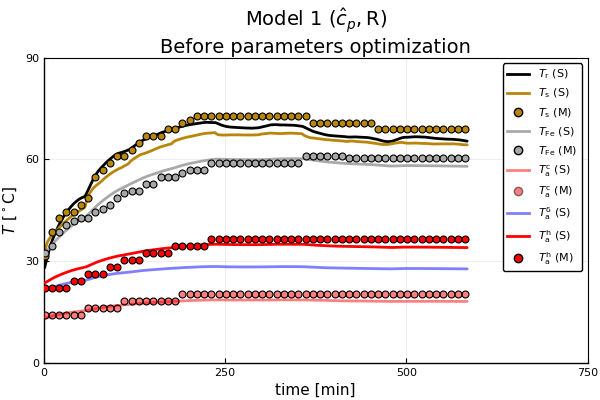

In [16]:
u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mFe,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = fill(1.,12) 
prob = ODEProblem(gen,u0,tspan,p)
sol = solve(prob, Euler(),dt=30.,saveat=60.)
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM1bf = sol[1,:]
TadM1bf = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM1bf = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
idx = 1:10:N
# Plotting simulation versus measurement data for Model 1
plt = plot()
plot!(plt,sol[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model1before=plot!(title="Model 1 (\$\\hatc_p,\\mathrm{R}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

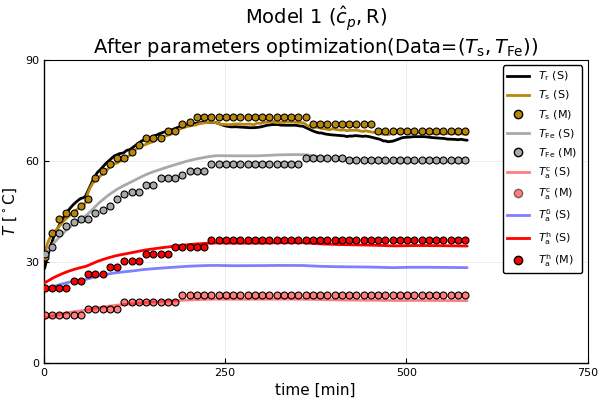

In [17]:
# Using data = (Ts, TFe) only
dataTwo = [data[1,:] data[2,:]]'
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, Tsit5(),dt = 30, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-data_r)^2/2/N
end
step = 60.
# Initial value of loss function
loss = (p) -> cost(p,gen,u0,tspan,step,dataTwo)
# p = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model1_data2 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model1_data2
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model1_data2 = @. res_model1_data2*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(), dt=30, saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM1data2 = sol_after[1,:]
TadM1data2 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM1data2 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model1afterUsingData2=plot!(title="Model 1 (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

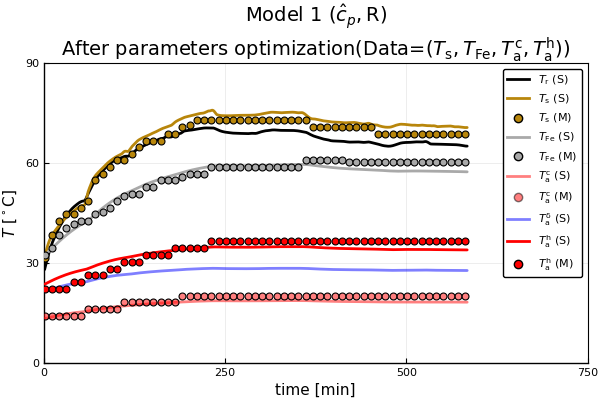

In [18]:
# Using data = (Ts, TFe, Tac, Tah)
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob,Tsit5(),dt=30, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/2/N
end
# Initial value of loss function
loss = (p) -> cost(p,gen,u0,tspan,dt,data)
# Saving solution at 1 min
dt = 60.
# p = [mFe,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model1_data4 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model1_data4
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model1_data4 = @. res_model1_data4*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(),dt=30, saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM1data4 = sol_after[1,:]
TadM1data4 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM1data4 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model1afterUsingData4=plot!(title="Model 1 (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T_\\mathrm{a}^\\mathrm{c},T_\\mathrm{a}^\\mathrm{h}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

# Model 2 starts

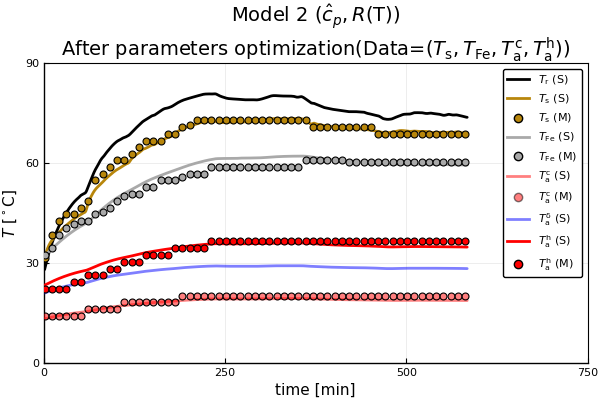

In [19]:
# Model 2
function gen(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25. 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*(1+alphaCu*(Tr-TCu_o))*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*chpCu)
    du[2] = (3*Rs*(1+alphaCu*(Ts-TCu_o))*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*chpCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*chpFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
   # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mFe,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = fill(1.,12)
prob = ODEProblem(gen,u0,tspan,p)
sol = solve(prob, Tsit5(), dt=30, saveat=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM2bf = sol[1,:]
TadM2bf = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM2bf = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
idx = 1:10:N
# Plotting simulation versus measurement data for Model 1
plt = plot()
plot!(plt,sol[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model2before=plot!(title="Model 2 (\$\\hatc_p,R\\mathrm{(T)}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

# Using data = (Ts, TFe) only
dataTwo = [data[1,:] data[2,:]]'
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob,Tsit5(),dt=30, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-data_r)^2/2/N
end
# Initial value of loss function
loss = (p) -> cost(p,gen,u0,tspan,dt,dataTwo)
# Saving solution at 1 min
dt = 60.
# p = [mFe,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model2_data2 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model2_data2
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model2_data2 = @. res_model2_data2*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(), dt=30, saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM2data2 = sol_after[1,:]
TadM2data2 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM2data2 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model2afterUsingData2=plot!(title="Model 2 (\$\\hatc_p,R\\mathrm{(T)}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

# Using data = (Ts, TFe, Tac, Tah)
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob,Tsit5(),dt=30, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/2/N
end
# Initial value of loss function
loss = (p) -> cost(p,gen,u0,tspan,dt,data)
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model2_data4 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model2_data4
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model2_data4 = @. res_model2_data4*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(), dt=30, saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM2data4 = sol_after[1,:]
TadM2data4 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM2data4 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model2afterUsingData4=plot!(title="Model 2 (\$\\hatc_p,R\\mathrm{(T)}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T_\\mathrm{a}^\\mathrm{c},T_\\mathrm{a}^\\mathrm{h}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

# Model 3a starts

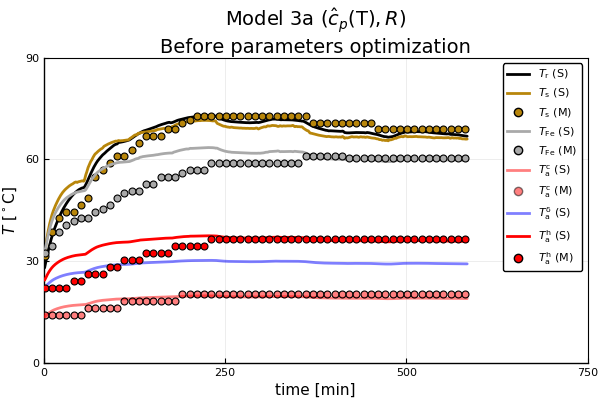

In [4]:
# Model 3a
function gen(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*R*(aCu+bCu*Tr)/MCu)
    du[2] = (3*Rs*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*R*(aCu+bCu*Ts)/MCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*R*(aFe+bFe*TFe)/MFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    # Auxiliary parameters
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
p = fill(1.,12)
prob = ODEProblem(gen,u0,tspan,p)
sol = solve(prob, Tsit5(), dt=30, saveat=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM3abf = sol[1,:]
TadM3abf = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM3abf = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
idx = 1:10:N
# Plotting simulation versus measurement data for Model 1
plt = plot()
plot!(plt,sol[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3abefore=plot!(title="Model 3a (\$\\hatc_p\\mathrm{(T)},R\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

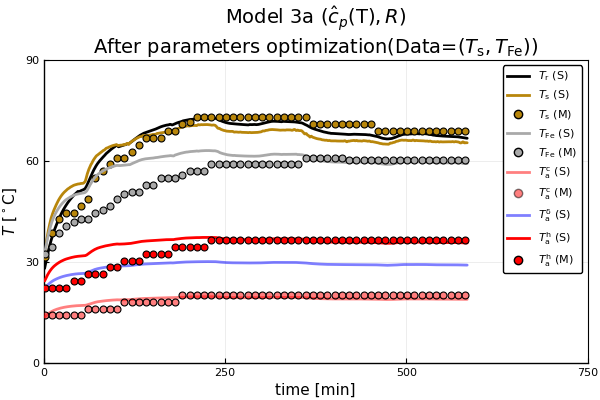

In [7]:
# Using data = (Ts, TFe) only
dataTwo = [data[1,:] data[2,:]]'
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob,Tsit5(),dt=30, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-data_r)^2/2/N
end
# Initial value of loss function
step = 60
loss = (p) -> cost(p,gen,u0,tspan,step,dataTwo)
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model3a_data2 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model3a_data2
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model3a_data2 = @. res_model3a_data2*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(), dt=30, saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM3adata2 = sol_after[1,:]
TadM3adata2 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM3adata2 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3aafterUsingData2=plot!(title="Model 3a (\$\\hatc_p\\mathrm{(T)},R\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

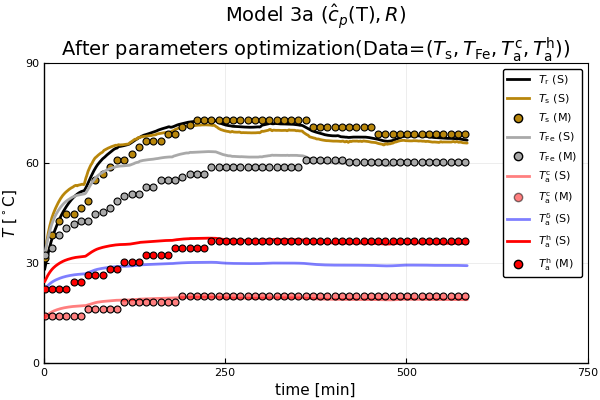

In [8]:
# Using data = (Ts, TFe, Tac, Tah)
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob,Tsit5(),dt=30, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/2/N
end
# Initial value of loss function
loss = (p) -> cost(p,gen,u0,tspan,step,data)
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model3a_data4 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model3a_data4
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model3a_data4 = @. res_model3a_data4*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(), dt=30, saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM3adata4 = sol_after[1,:]
TadM3adata4 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM3adata4 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3aafterUsingData4=plot!(title="Model 3a (\$\\hatc_p\\mathrm{(T)},R\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T_\\mathrm{a}^\\mathrm{c},T_\\mathrm{a}^\\mathrm{h}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

# Model 4a starts

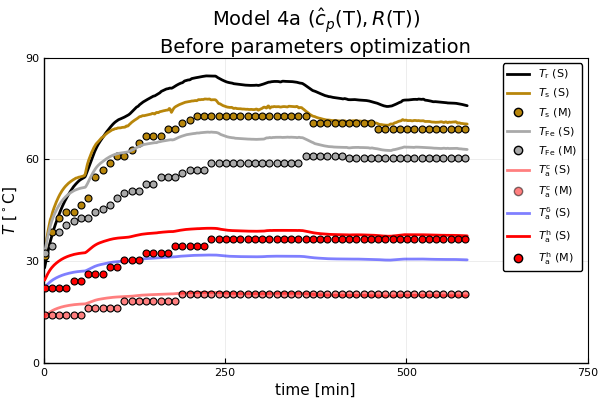

In [9]:
# Model 4a
function gen(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*(1+alphaCu*(Tr-TCu_o))*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*R*(aCu+bCu*Tr)/MCu)
    du[2] = (3*Rs*(1+alphaCu*(Ts-TCu_o))*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*R*(aCu+bCu*Ts)/MCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*R*(aFe+bFe*TFe)/MFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,0.127e-3,
                                                            1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # parameters to be optimized
    # p = mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw
    # Normalized parameters values
    Nmr,Nms,NmFe,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    # Auxiliary parameters
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mFe,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = fill(1.,12)
prob = ODEProblem(gen,u0,tspan,p)
sol = solve(prob, Tsit5(), dt=30,saveat=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)
# saving for Tr and Tad for later plot
TrM4abf = sol[1,:]
TadM4abf = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM4abf = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
idx = 1:10:N
# Plotting simulation versus measurement data for Model 4a
plt = plot()
plot!(plt,sol[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4abefore=plot!(title="Model 4a (\$\\hatc_p\\mathrm{(T)},R\\mathrm{(T)}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

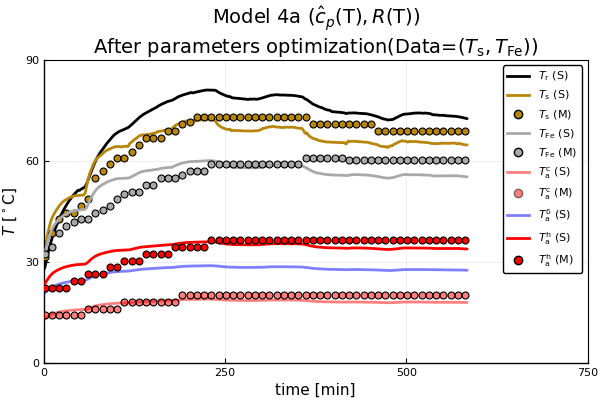

In [11]:
# Using data = (Ts, TFe) only
dataTwo = [data[1,:] data[2,:]]'
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob,Tsit5(),dt=30, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-data_r)^2/2/N
end
# Initial value of loss function
step = 60
loss = (p) -> cost(p,gen,u0,tspan,step,dataTwo)
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model4a_data2 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model4a_data2
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model4a_data2 = @. res_model4a_data2*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(), dt=30,saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
TrM4adata2 = sol_after[1,:]
TadM4adata2 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM4adata2 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4aafterUsingData2=plot!(title="Model 4a (\$\\hatc_p\\mathrm{(T)},R\\mathrm{(T)}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

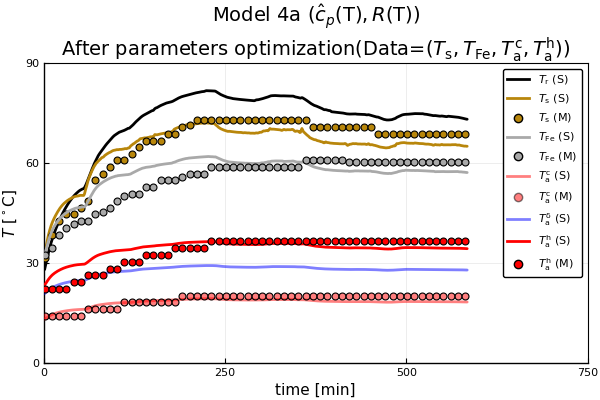

In [12]:
# Using data = (Ts, TFe, Tac, Tah)
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, Tsit5(),dt=30,saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/2/N
end
# Initial value of loss function
step = 60
loss = (p) -> cost(p,gen,u0,tspan,step,data)
p = fill(1.,12) 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model4a_data4 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent())).minimizer
# setting optimized parameter and solving ODE
p = res_model4a_data4
# saving optimized parameter
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model4a_data4 = @. res_model4a_data4*unoptimized
#
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, Tsit5(), dt=30,saveat=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)
TrM4adata4 = sol_after[1,:]
TadM4adata4 = algVar[2,:]
# Calculating and saving RMSE for model
RMSEM4adata4 = sqrt(norm([Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']-data,2)^2/4/N)
plt = plot()
plot!(plt,sol_after[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:black,lw=2)
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")
plot!(plt,algVar[2,:],label=L"T_\mathrm{a}^\mathrm{\delta}\ \mathrm{(S)}",lc=:blue,lw=2,la=0.5)
plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4aafterUsingData4=plot!(title="Model 4a (\$\\hatc_p\\mathrm{(T)},R\\mathrm{(T)}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T_\\mathrm{a}^\\mathrm{c},T_\\mathrm{a}^\\mathrm{h}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,90),framestyle = :box, legend=:topright)

In [2]:
# Displaying results

Array{Float64,1}[[1.00047, 1.20729, 1.00354, 0.999843, 0.77408, 0.975618, 0.985571, 0.996471, 1.02062, 1.01364, 0.991241, 0.998559], [0.993171, 1.53415, 1.00556, 1.00706, 0.479418, 1.01435, 0.992871, 0.998158, 0.989385, 0.999099, 1.00826, 0.999135]]
Tuple{Array{Float64,1},Array{Float64,1}}[([9264.31, 8242.15, 71452.1, 2.69958

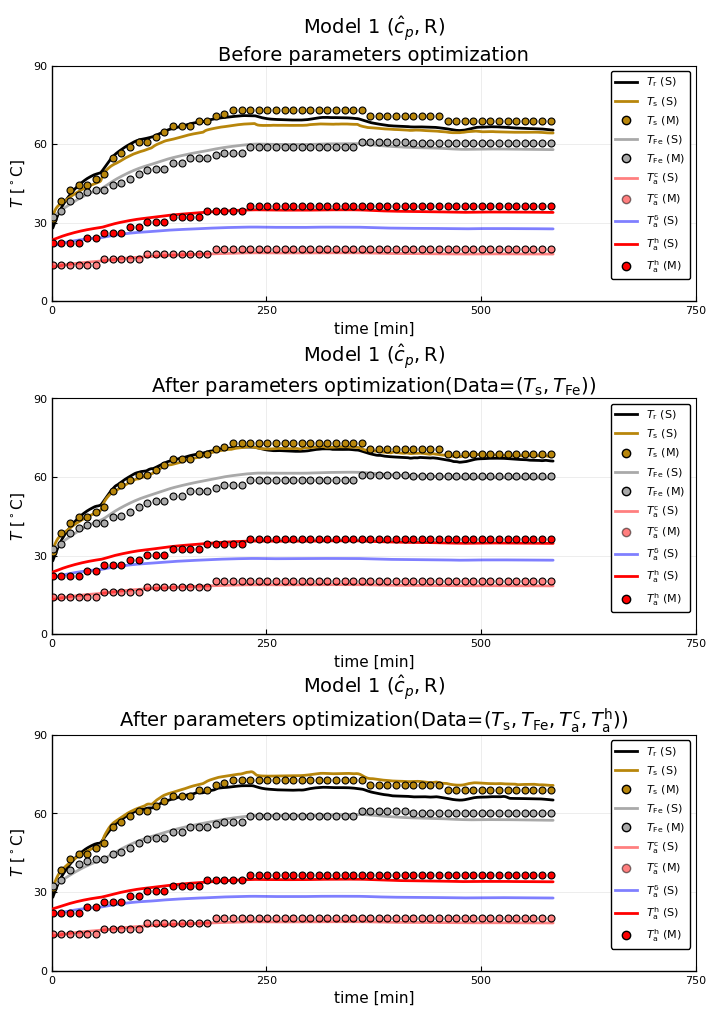

, 15.4816, 13.9513, 54.7977, 221.217, 216.371, 535.202, 53.4279, 49.1291], [9196.76, 10473.7, 71595.8, 2.71907, 9.58836, 14.5052, 55.2036, 221.591, 209.75, 527.524, 54.345, 49.1575])]
Tuple{Array{Float64,1},Array{Float64,1}}[([0.04652, 20.73, 0.3541, -0.0157, -22.59, -2.438, -1.443, -0.3529, 2.062, 1.364, -0.8759, -0.1441], [-0.6829, 53.42, 0.5559, 0.7064, -52.06, 1.435, -0.7129, -0.1842, -1.061, -0.09011, 0.8257, -0.08648])]
[2.8008, 1.76567, 1.84668]

In [38]:
# Model 1
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
res_model1=[res_model1_data2,res_model1_data4]
optimized_model1=[@. res_model1_data2*unoptimized,@. res_model1_data4*unoptimized]
per_changed = [@. round((res_model1[1]-1)*100;sigdigits=4),@. round((res_model1[2]-1)*100;sigdigits=4)]
RMSEM2 = [RMSEM1bf, RMSEM1data2, RMSEM1data4]
print(res_model1)
print("\n")
print(optimized_model1)
print("\n")
print(per_changed)
print("\n")
print(RMSEM2)
plot(Model1before,
Model1afterUsingData2,
Model1afterUsingData4,layout=(3,1),size=(700,1000))
figfile = "Model1fitted.svg"
savefig(figpath*figfile)

Array{Float64,1}[[1.00153, 1.17417, 1.00583, 1.0007, 0.821191, 1.03043, 1.01963, 1.00519, 0.972017, 0.981514, 1.01192, 1.00232], [1.00227, 2.0025, 1.00862, 0.999172, 0.789705, 1.02656, 1.00502, 1.00093, 0.976624, 0.982031, 1.0258, 1.00061]]
Tuple{Array{Float64,1},Array{Float64,1}}[([9274.14, 8016.05, 71615.2, 2.70189, 16.4238, 14.7352, 56.6915, 223.153, 206.068, 518.24, 54.5426, 49.3143], [9281.01, 13671.1, 71813.4, 2.69776, 15.7941, 14.6798, 55.879, 222.207, 207.044, 518.512, 55.2906, 49.23])]
Tuple{Array{Float64,1},Array{Float64,1}}[([0.1527, 17.42, 0.5832, 0.07011, -17.88, 3.043, 1.963, 0.5193, -2.

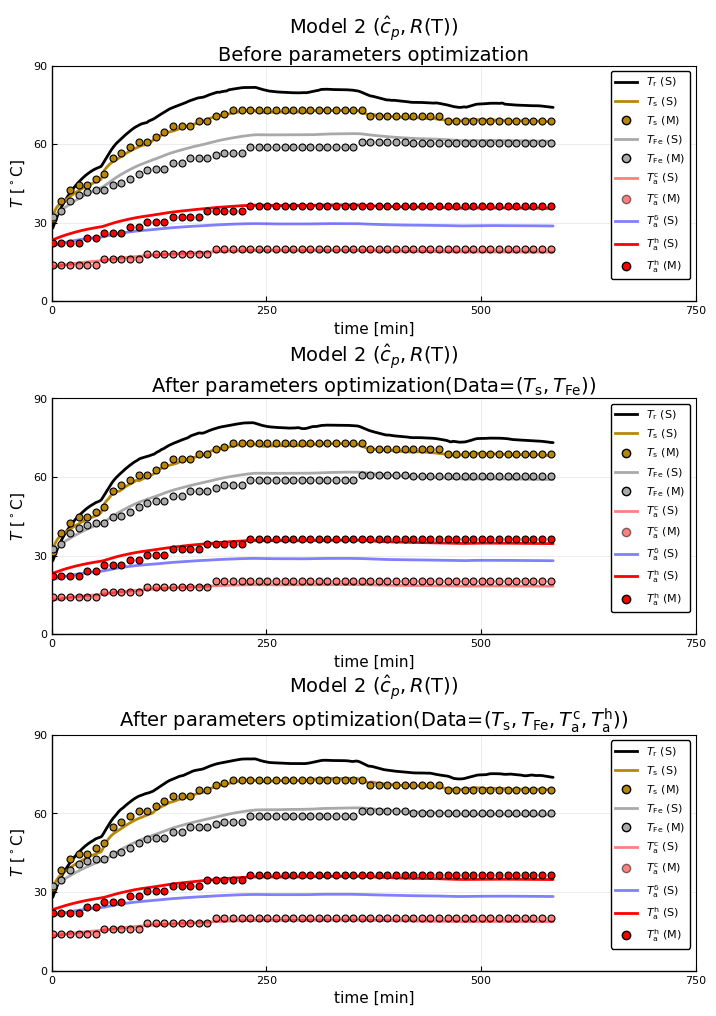

798, -1.849, 1.192, 0.2323], [0.2269, 100.3, 0.8615, -0.08281, -21.03, 2.656, 0.5017, 0.09326, -2.338, -1.797, 2.58, 0.06092])]
[2.06186, 1.56998, 1.493]

In [35]:
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
res_model2=[res_model2_data2,res_model2_data4]
optimized_model2=[@. res_model2_data2*unoptimized,@. res_model2_data4*unoptimized]
per_changed = [@. round((res_model2[1]-1)*100;sigdigits=4),@. round((res_model2[2]-1)*100;sigdigits=4)]
RMSEM2 = [RMSEM2bf, RMSEM2data2, RMSEM2data4]
print(res_model2)
print("\n")
print(optimized_model2)
print("\n")
print(per_changed)
print("\n")
print(RMSEM2)
plot(Model2before,
Model2afterUsingData2,
Model2afterUsingData4,layout=(3,1),size=(700,1000))
figfile = "Model2fitted.svg"
savefig(figpath*figfile)

Array{Float64,1}[[1.00024, 0.957355, 0.95583, 0.99979, 1.04164, 1.00593, 1.00417, 1.00105, 0.993346, 0.995495, 1.0027, 1.00047], [1.0, 1.00001, 1.00004, 1.0, 1.00007, 0.999974, 0.999974, 1.0, 1.00002, 1.00003, 1.0, 1.0]]
Tuple{Array{Float64,1},Array{Float64,1}}[([9262.25, 6535.86, 68055.1, 2.69943, 20.8328, 14.3849, 55.8318, 222.233, 210.589, 525.621, 54.0454, 49.2231], [9260.0, 6827.04, 71203.2, 2.7, 20.0014, 14.2996, 55.5986, 222.0, 212.005, 528.013, 53.9002, 49.2])]
Tuple{Array{Float64,1},Array{Float64,1}}[(

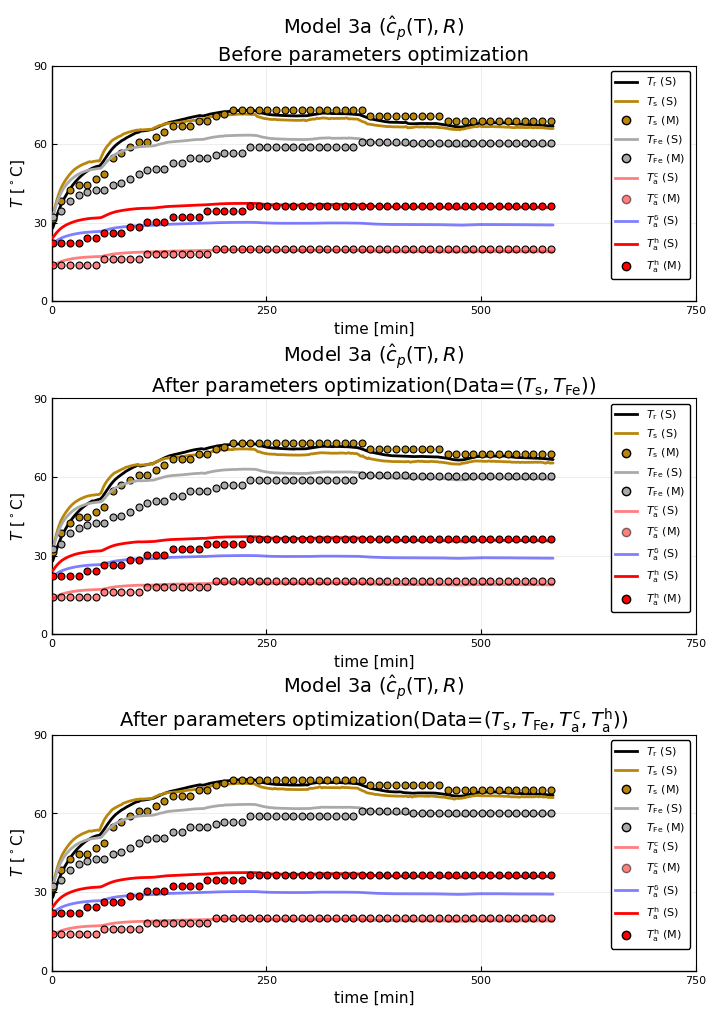

[0.02432, -4.265, -4.417, -0.02095, 4.164, 0.5934, 0.4168, 0.1051, -0.6654, -0.4505, 0.2698, 0.04691], [2.721e-5, 0.00065, 0.004431, -2.181e-5, 0.006866, -0.002596, -0.002583, 0.000122, 0.002415, 0.002544, 0.0003276, 5.494e-5])]
[3.89743, 3.85705, 3.89534]

In [36]:
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
res_model3a=[res_model3a_data2,res_model3a_data4]
optimized_model3a=[@. res_model3a_data2*unoptimized,@. res_model3a_data4*unoptimized]
per_changed = [@. round((res_model3a[1]-1)*100;sigdigits=4),@. round((res_model3a[2]-1)*100;sigdigits=4)]
RMSEM3a = [RMSEM3abf, RMSEM3adata2, RMSEM3adata4]
print(res_model3a)
print("\n")
print(optimized_model3a)
print("\n")
print(per_changed)
print("\n")
print(RMSEM3a)
plot(Model3abefore,
Model3aafterUsingData2,
Model3aafterUsingData4,layout=(3,1),size=(700,1000))
figfile = "Model3afitted.svg"
savefig(figpath*figfile)

Array{Float64,1}[[1.00362, 0.80083, 0.842252, 0.999763, 0.784058, 1.10678, 1.07238, 1.01858, 0.896536, 0.92797, 1.04643, 1.00838], [1.00591, 1.05174, 0.963824, 0.996155, 0.

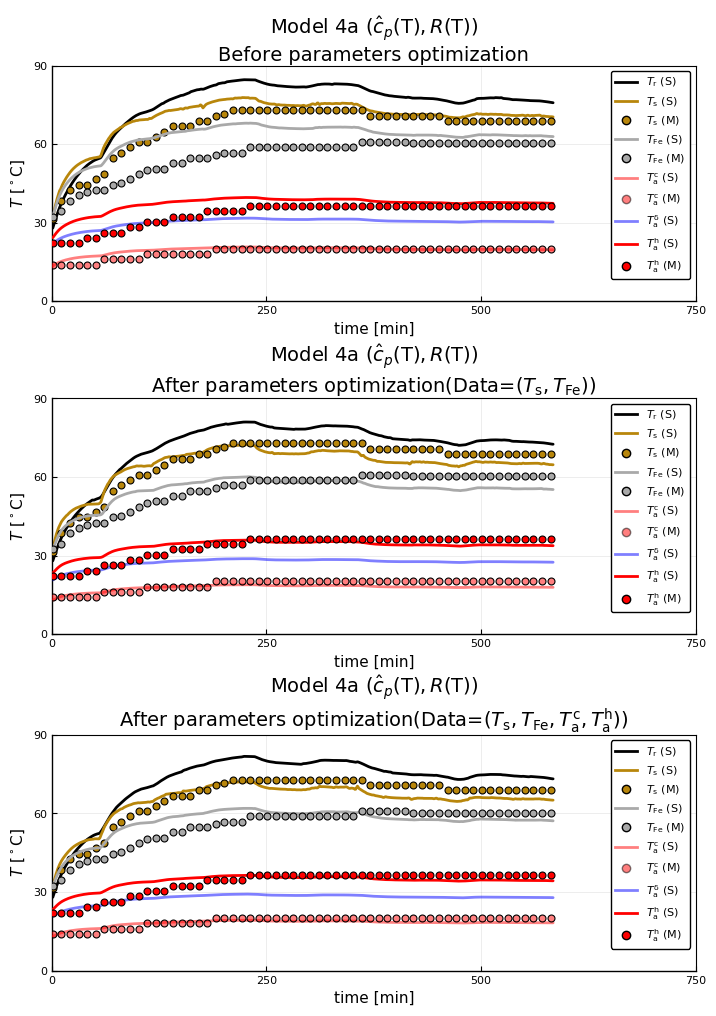

94201, 1.05865, 1.05966, 1.01459, 0.927358, 0.933492, 1.0486, 1.00654]]
Tuple{Array{Float64,1},Array{Float64,1}}[([9293.52, 5467.27, 59968.4, 2.69936, 15.6812, 15.827, 59.6242, 226.125, 190.066, 489.968, 56.4027, 49.6121], [9314.68, 7180.22, 68624.3, 2.68962, 18.8402, 15.1386, 58.9173, 225.24, 196.6, 492.884, 56.5195, 49.5219])]
Tuple{Array{Float64,1},Array{Float64,1}}[([0.362, -19.92, -15.77, -0.02373, -21.59, 10.68, 7.238, 1.858, -10.35, -7.203, 4.643, 0.8376], [0.5905, 5.174, -3.618, -0.3845, -5.799, 5.865, 5.966, 1.459, -7.264, -6.651, 4.86, 0.6542])]
[5.25405, 3.24498, 3.15849]

In [37]:
mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,71200.,2.7,20,14.3,55.6,222.,212.,528.,53.9,49.2
unoptimized = [mr,ms,mFe,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
res_model4a=[res_model4a_data2,res_model4a_data4]
optimized_model4a=[@. res_model4a_data2*unoptimized,@. res_model4a_data4*unoptimized]
per_changed = [@. round((res_model4a[1]-1)*100;sigdigits=4),@. round((res_model4a[2]-1)*100;sigdigits=4)]
RMSEM4a = [RMSEM4abf, RMSEM4adata2, RMSEM4adata4]
print(res_model4a)
print("\n")
print(optimized_model4a)
print("\n")
print(per_changed)
print("\n")
print(RMSEM4a)
plot(Model4abefore,
Model4aafterUsingData2,
Model4aafterUsingData4,layout=(3,1),size=(700,1000))
figfile = "Model4afitted.svg"
savefig(figpath*figfile)

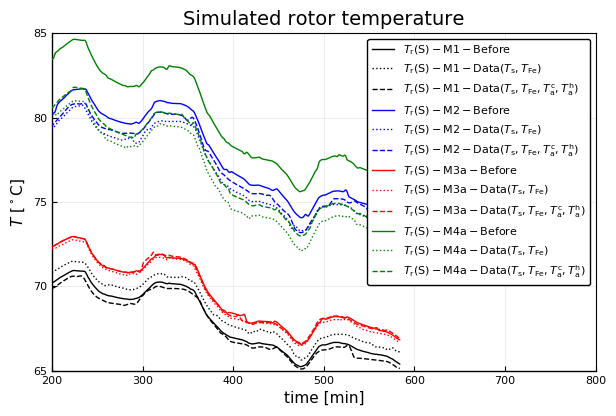

In [78]:
# Visualizing Tr and Tad for other models
plt=plot()
plot!(plt,TrM1bf,label=L"T_\mathrm{r}\mathrm{(S)-M1-Before}",lc=:black,ls=:solid)
plot!(plt,TrM1data2,label=L"T_\mathrm{r}\mathrm{(S)-M1-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:black,ls=:dot)
plot!(plt,TrM1data4,label=L"T_\mathrm{r}\mathrm{(S)-M1-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:black,ls=:dash)
plot!(plt,TrM2bf,label=L"T_\mathrm{r}\mathrm{(S)-M2-Before}",lc=:blue,ls=:solid)
plot!(plt,TrM2data2,label=L"T_\mathrm{r}\mathrm{(S)-M2-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:blue,ls=:dot)
plot!(plt,TrM2data4,label=L"T_\mathrm{r}\mathrm{(S)-M2-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:blue,ls=:dash)
plot!(plt,TrM3abf,label=L"T_\mathrm{r}\mathrm{(S)-M3a-Before}",lc=:red,ls=:solid)
plot!(plt,TrM3adata2,label=L"T_\mathrm{r}\mathrm{(S)-M3a-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:red,ls=:dot)
plot!(plt,TrM3adata4,label=L"T_\mathrm{r}\mathrm{(S)-M3a-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:red,ls=:dash)
plot!(plt,TrM4abf,label=L"T_\mathrm{r}\mathrm{(S)-M4a-Before}",lc=:green,ls=:solid)
plot!(plt,TrM4adata2,label=L"T_\mathrm{r}\mathrm{(S)-M4a-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:green,ls=:dot)
plot!(plt,TrM4adata4,label=L"T_\mathrm{r}\mathrm{(S)-M4a-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:green,ls=:dash)
plot!(title="Simulated rotor temperature",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(200,800),ylim=(65,85),framestyle = :box, legend=:topright)
figfile = "simulatedTr.svg"
savefig(figpath*figfile)

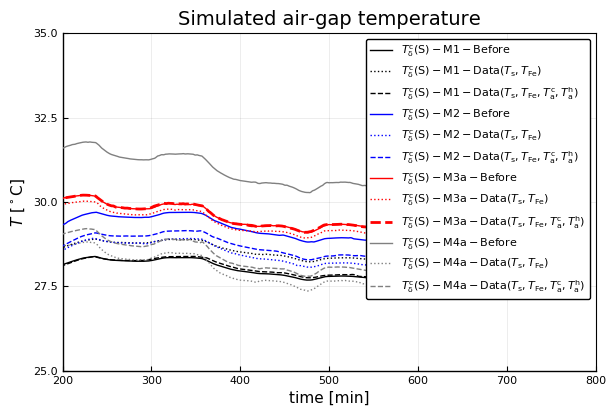

In [86]:
plt=plot()
plot!(plt,TadM1bf,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M1-Before}",lc=:black,ls=:solid)
plot!(plt,TadM1data2,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M1-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:black,ls=:dot)
plot!(plt,TadM1data4,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M1-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:black,ls=:dash)
plot!(plt,TadM2bf,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M2-Before}",lc=:blue,ls=:solid)
plot!(plt,TadM2data2,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M2-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:blue,ls=:dot)
plot!(plt,TadM2data4,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M2-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:blue,ls=:dash)
plot!(plt,TadM3abf,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M3a-Before}",lc=:red,ls=:solid)
plot!(plt,TadM3adata2,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M3a-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:red,ls=:dot)
plot!(plt,TadM3adata4,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M3a-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:red,lw=2,ls=:dash)
plot!(plt,TadM4abf,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M4a-Before}",lc=:grey,ls=:solid)
plot!(plt,TadM4adata2,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M4a-Data}(T_\mathrm{s},T_\mathrm{Fe})",lc=:grey,ls=:dot)
plot!(plt,TadM4adata4,label=L"T^\mathrm{c}_\mathrm{\delta}\mathrm{(S)-M4a-Data}(T_\mathrm{s},T_\mathrm{Fe},T^\mathrm{c}_\mathrm{a},T^\mathrm{h}_\mathrm{a})",lc=:grey,ls=:dash)
plot!(title="Simulated air-gap temperature",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(200,800),ylim=(25,35),framestyle = :box, legend=:topright)
figfile = "simulatedTad.svg"
savefig(figpath*figfile)